In [1]:
import numpy as np

import matplotlib.pyplot as plt

import h5py as hp

%matplotlib widget

In [76]:
inputDir='Z:/shared_hackathon/test/'

In [92]:
import os,sys
from os import listdir
from os.path import join
def getfiles(path,imgtype):
    return [join(path,name) for name in listdir(path) if name.endswith(imgtype)]

def definefilelist(Dir,imgtype):
    fileDirList=getfiles(Dir,imgtype)
    imagetypelength=1+len(imgtype)
    fileNameList=[os.path.split(fileDir)[1][:-imagetypelength] for fileDir in fileDirList]
    fileNameList.sort()

    return fileNameList

def create_haadf_mask(array_shape,radii,center=None):
    """
    Generates the mask for virtual haaadf detector
    Args:
        array_shape: tuple or list with the shape of the diffraction pattern
        radii: list of [inner radius, outer radius]
        center: center of the bright field disk, if not specified will set to the center of the array
    Returns:
        np.ndarray: 2D boolean array 
    """
    [r0,r1]=radii
    if center is None:
        center=[array_shape[-2]/2,array_shape[-1]/2]
    kx = np.arange(array_shape[-1])-int(center[-1])
    ky = np.arange(array_shape[-2])-int(center[-2])
    kx,ky = np.meshgrid(kx,ky)
    kdist = (kx**2.0 + ky**2.0)**(1.0/2)
    haadf_mask = np.logical_and(kdist <= r1, kdist >= r0)
    return haadf_mask  

In [173]:
def generate_gaussian_blob(x_dim, y_dim, x_peak_positions, y_peak_positions,amplitudes, std_dev):
    """Generates a 2D array with Gaussian blobs.
    
    Args:
        x_dim (int): Width of the array.
        y_dim (int): Height of the array.
        peak_positions (list of tuples): List of (x, y) coordinates for the Gaussian peaks.
        amplitudes (list of floats): List of amplitudes for each Gaussian blob.
        std_devs (list of floats): List of standard deviations for each Gaussian blob.
    
    Returns:
        np.ndarray: 2D array with Gaussian blobs.
    """
    # Initialize the 2D array with zeros
    array = np.zeros((x_dim, y_dim),dtype=np.float32)
    
    # Create coordinate grids for x and y
    x = np.arange(x_dim)
    y = np.arange(y_dim)
    yv, xv = np.meshgrid(y, x)
    
    # Add Gaussian blobs to the array
    for x_peak, y_peak, amplitude in zip(x_peak_positions,y_peak_positions, amplitudes):
        exponent = -((xv - x_peak)**2 + (yv - y_peak)**2) / (2 * std_dev**2)
        gaussian_blob = amplitude * np.exp(exponent)
        array += gaussian_blob
    
    return array

In [193]:
inputDir='Z:/shared_hackathon/test2/'

In [194]:
fileNameList=definefilelist(inputDir,'hdf5')

In [195]:
scanWidth = 11.715
real_sampling=0.2
radius_smooth=1
rx,ry,kx,ky=(59,59,64,64)


atoms=read_ase_file('Z:/shared_hackathon//STO_Pm-3m.cif')
sc = atoms*(4,4,24)
all_positions=sc.get_positions()
initial_z_number=sc.get_atomic_numbers()
a_sites=(initial_z_number==38)
b_sites=initial_z_number==8
c_sites=initial_z_number==22

saveDir='Z:/shared_hackathon/test2_Z_map/'
os.mkdir(saveDir)

for i in range(len(fileNameList)):
    filename=fileNameList[i]
    if 'noTDS' in filename:
        continue
    ztext=filename.split('-')[0][1:]
    z_list=[int(f) for f in ztext.split('_')]
    boolean_messedup_Z=0
    for j in range(3):
        if z_list[j] in [8,22,38]:
            boolean_messedup_Z=1
    if boolean_messedup_Z:
        continue
    
    rand_z_number=np.copy(initial_z_number)

    rand_z_number[a_sites]=z_list[0]
    rand_z_number[b_sites]=z_list[1]
    rand_z_number[c_sites]=z_list[2]


    x0=float(filename.split('x0')[1].split('-')[0])
    y0=float(filename.split('y0')[1].split('_')[0])

    mask_x=np.logical_and(all_positions[:,0]>=x0,all_positions[:,0]<=x0+scanWidth)
    mask_y=np.logical_and(all_positions[:,1]>=y0,all_positions[:,1]<=y0+scanWidth)
    mask_xy=np.logical_and(mask_x,mask_y)
    selected_z=rand_z_number[mask_xy]
    
    x_pos=(all_positions[mask_xy][:,0]-x0)/real_sampling
    y_pos=(all_positions[mask_xy][:,1]-y0)/real_sampling
    z_map=generate_gaussian_blob(rx,ry,x_pos,y_pos,selected_z,radius_smooth)/24
    print(filename, np.mean(z_map))
    np.save(saveDir+'/'+filename.split('_TDS')[0]+'.npy',z_map)

z10_10_47-x01.01-y00.93_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc 1.4133105
z10_24_55-x00.93-y00.91_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc 2.2255576
z10_36_19-x01.08-y00.91_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc 2.2255573
z10_61_67-x01.09-y00.81_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc 4.2236795
z10_70_14-x00.94-y01.0_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc 3.8013177
z10_91_85-x01.05-y01.13_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc 5.97814
z10_94_84-x00.88-y01.09_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc 6.1080985
z11_25_96-x01.05-y01.0_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc 2.9565806
z11_55_86-x00.8-y01.11_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc 4.256168
z11_88_47-x01.04-y00.94_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc 5.2308726
z11_93_85-x00.92-y01.01_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc 6.09

In [198]:
fileNameList[i-1]

'z9_82_29-x00.83-y00.82_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc'

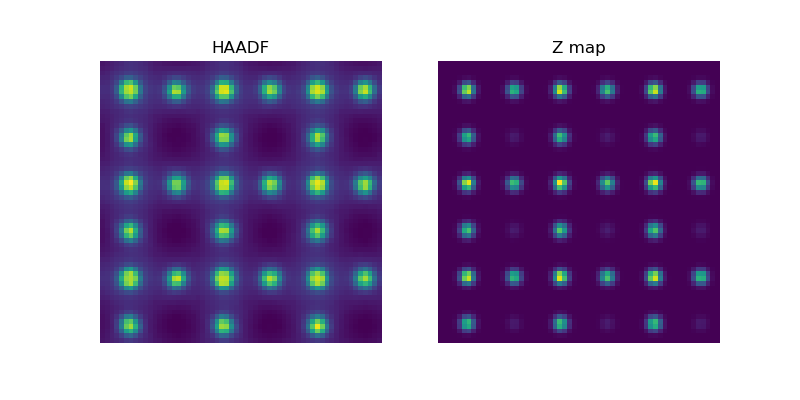

In [203]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(121)
ax2=fig.add_subplot(122)
f=hp.File(inputDir+fileNameList[i-1]+'.hdf5','r')
dp=f['array'][...]
# ax.imshow(np.log(np.mean(f['array'],axis=(0,1))))
haadf=np.mean(dp*create_haadf_mask([64,64],[30,32]),axis=(-2,-1))
ax.imshow(haadf)
ax2.imshow(z_map)
ax.set_title('HAADF')
ax2.set_title('Z map')
ax.axis('off')
ax2.axis('off')
fig.savefig('Z:/shared_hackathon/HAADF_vs_Zmap_z9_82_29-x00.83-y00.82_TDS64iso_gaussiansigma_1.png')
# fileNameList[198]

In [218]:
result=np.load('Z:shared_hackathon/result_prediction (1).npz')

In [209]:
def RingMean(diff_slice,center):
    (kx,ky)=diff_slice.shape
    [xx,yy]=np.meshgrid(np.arange(kx),np.arange(ky),indexing='ij')
    xx=xx-center[0]
    yy=yy-center[1]
    rr=np.sqrt(xx**2+yy**2)
    circleIntegrate=np.zeros(int(rr.max())-1,dtype='float32')
    for i in range(len(circleIntegrate)):
        del_mask=np.logical_and(rr>=i,rr<i+1)
        circleIntegrate[i]=np.average(diff_slice[del_mask])
    return circleIntegrate

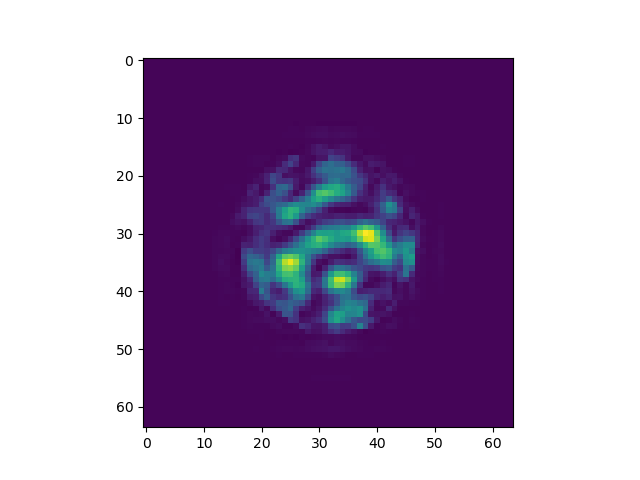

In [223]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.imshow(result['Ground'])

In [228]:
f['sampling'][...]

array([0.19855932, 0.19855932, 1.91029773, 1.91029773])

inputDP
groundTruth
prediction


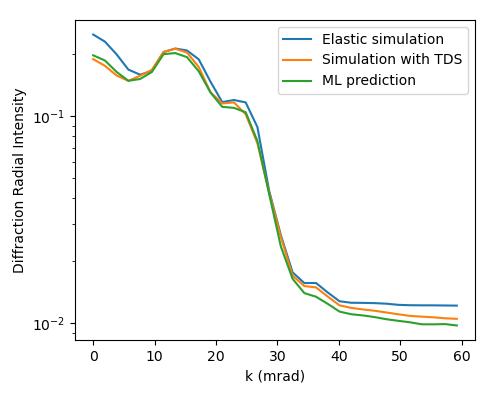

In [235]:
fig=plt.figure(figsize=(5,4))
ax=fig.add_axes([0.15,0.15,0.8,0.8])
k_array=np.arange(32)*1.91
labels=['Elastic simulation', 'Simulation with TDS','ML prediction']
for i in range(3):
    key=list(result.keys())[i]
    print(key)
    ring1D=RingMean(result[key],center=[32,32])[:32]
    ax.plot(k_array,ring1D,label=labels[i])
ax.set_yscale('log')
ax.legend()
ax.set_ylabel('Diffraction Radial Intensity')
ax.set_xlabel('k (mrad)')
fig.savefig('Z:/shared_hackathon/Radial_average_comparison.png')